<a href="https://colab.research.google.com/github/dave20874/rl-exercises/blob/main/ex_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
%matplotlib inline

from matplotlib import pyplot as plt 
from numpy import random

This notebook implements exercise 2.5 from Sutton and Barto's Reinforcement Learning.

Our first class, Bandit, represents the non-stationary 10-Armed Bandit.  All the q_star(a) start out equal (at 0.0) and update with a random walk of mean 0, std dev 0.01.

The update method updates the rewards on each time step.  The play method generates a random reward based on the players choice of action.  (play and update are independent so we can simulate agents with various epsilon-greedy behaviors together.)

In [53]:
class Bandit:
  REWARD_VARIANCE = 1.0
  UPDATE_STD_DEV = 0.01

  def __init__(self, num_actions=10):
    # number of actions for this bandit
    self.num_actions = num_actions

    # Mean and std deviation for each action's reward
    # self.mean_r[N] -> mean reward for action N.
    # (Variance is 1.0 for all actions.  Std Dev = sqrt(variance) is also 1.)
    self.mean_r = [1.0]*self.num_actions

  # Return the ideal Q, q_star, for this bandit at this time.
  def get_q_star(self):
    return max(self.mean_r)

  # return the best action for this bandit at this time.
  def get_best_action(self):
    return self.mean_r.index(max(self.mean_r))

  # update distribution on each time step
  def update(self):
    for i in range(len(self.mean_r)):
      self.mean_r[i] += random.normal(0.0, self.UPDATE_STD_DEV)

  # Play the game!  Get a reward!
  def play(self, action):
    mean = self.mean_r[action]
    r = random.normal(mean, self.REWARD_VARIANCE)
    return r



  



The next class defines the Agent.  It uses a parameter, alpha to set the step size and epsilon to set the learning rate.  An alpha value of 0.0 tells the agent to use sample averages instead of a constant step size.

In [54]:
class Agent:
  def __init__(self, alpha, epsilon, num_actions=10):
    self.alpha = alpha      # step size.  0.0 means use 1.0/self.n[a]
    self.epsilon = epsilon  # Exploration rate
    self.num_actions = num_actions
    self.n = 0              # steps taken

    # estimated Q values
    self.q = [0.0]*self.num_actions
    self.n = [0]*self.num_actions       # number of steps for this action

  def get_greedy_action(self):
    return self.q.index(max(self.q))

  # Play one round with the bandit.
  def play(self, bandit):
    # Decide random or greedy action
    action = self.get_greedy_action()
    if random.uniform(0.0, 1.0) < self.epsilon:
      # override greedy with random action
      action = random.randint(0, self.num_actions)

    # Get reward for this action
    reward = bandit.play(action)

    # Update q, n for this action
    self.n[action] += 1
    if self.alpha == 0.0:
      # compute step size to give sample average
      step_size = 1.0/self.n[action]
    else:
      # use alpha as step size
      step_size = self.alpha

    self.q[action] += step_size*(reward-self.q[action])

    return (action, reward)
 

Now we can use our Bandit and Agent to set up an experiment.


In [55]:
class Experiment:
  RUNS = 1000
  NUM_ACTIONS = 10
  STEPS = 10000
  def __init__(self):
    self.agent1_rewards = [0.0]*self.STEPS
    self.agent1_pct_opt = [0.0]*self.STEPS
    self.agent2_rewards = [0.0]*self.STEPS
    self.agent2_pct_opt = [0.0]*self.STEPS
    self.optimal_reward = [0.0]*self.STEPS

  def do_runs(self):
    for n in range(self.RUNS):
      self.run(n+1)

  def run(self, run):
    alpha = 1.0/run

    # create bandit
    bandit = Bandit(self.NUM_ACTIONS)

    # create agents with different exploration rates
    epsilon = 0.1
    avg_agent = Agent(0.0, epsilon, self.NUM_ACTIONS)
    const_sz_agent = Agent(0.1, epsilon, self.NUM_ACTIONS)

    # go through the steps
    for step in range(self.STEPS):
      bandit.update()
      optimal = bandit.get_q_star()
      optimal_act = bandit.get_best_action()
      (act1, reward1) = avg_agent.play(bandit)
      pct1 = 1.0 if (act1 == optimal_act) else 0.0
      (act2, reward2) = const_sz_agent.play(bandit)
      pct2 = 1.0 if (act2 == optimal_act) else 0.0

      self.optimal_reward[step-1] += alpha*(optimal - self.optimal_reward[step-1])
      self.agent1_rewards[step-1] += alpha*(reward1 - self.agent1_rewards[step-1])
      self.agent1_pct_opt[step-1] += alpha*(pct1 - self.agent1_pct_opt[step-1])
      self.agent2_rewards[step-1] += alpha*(reward2 - self.agent2_rewards[step-1])
      self.agent2_pct_opt[step-1] += alpha*(pct2 - self.agent2_pct_opt[step-1])



In [56]:
exp = Experiment()
exp.do_runs()

# Generate plots of reward and %optimal reward
print(f"Optimal: {exp.optimal_reward[exp.STEPS-1]}, A: {exp.agent1_pct_opt[exp.STEPS-1]}, B: {exp.agent2_pct_opt[exp.STEPS-1]}")



Optimal: 1.0151379851075544, A: 0.09500000000000003, B: 0.09600000000000006


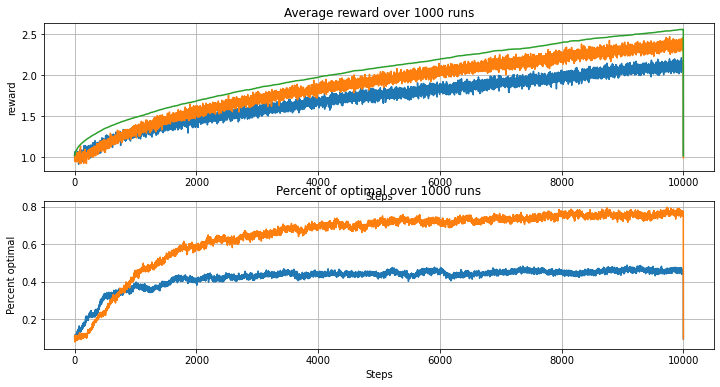

In [57]:
# data to plot
step = range(1, exp.STEPS+1)

fig, ax = plt.subplots(2)
ax[0].plot(step, exp.agent1_rewards, color='tab:blue')
ax[0].plot(step, exp.agent2_rewards, color='tab:orange')
ax[0].plot(step, exp.optimal_reward, color='tab:green')

ax[0].set(xlabel='Steps', ylabel='reward', title=f'Average reward over {exp.RUNS} runs')
ax[0].grid()

ax[1].plot(step, exp.agent1_pct_opt, color='tab:blue')
ax[1].plot(step, exp.agent2_pct_opt, color='tab:orange')

ax[1].set(xlabel='Steps', ylabel='Percent optimal', title=f'Percent of optimal over {exp.RUNS} runs')
ax[1].grid()

fig.set_size_inches(12.0, 6.0)
plt.show()